In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

In [2]:
mat = scipy.io.loadmat('MeasurementforMiniproject.mat')
X = np.array(mat['X'])
f = np.array(mat['f'])
f0 = np.array(mat['f0'])
r = np.array(mat['r'])
scen = np.array(mat['scen'])
tau = np.array(mat['tau'])
x =np.array(mat['x'])
X_synthetic = np.array(mat['X_synthetic'])
x_synthetic = np.array(mat['x_synthetic'])

In [3]:
print(f'f shape: {f.shape}') # frequency sweep (N=101 measured frequency points)
print(f'f0 shape: {f0.shape}') # carrier frequency
print(f'r shape: {r.shape}') # array sensor vectors: 71*66 = 4686
print(f'scen shape: {scen.shape}') # no f** clue what it is, but it's huge
print(f'tau shape: {tau.shape}') # delay shape (one delay for each impinging waves)
print(f'X shape: {X.shape}') # measured discrete space-frequency transfer function
print(f'x shape: {x.shape}') # measured discrete complex envelope of the wave field
print(f'X_synthetic shape: {X_synthetic.shape}') # synthetic discrete space-frequency transfer function
print(f'x_synthetic shape: {x_synthetic.shape}') # synthetic discrete complex envelope of the wave field

f shape: (101, 1)
f0 shape: (1, 1)
r shape: (2, 4686)
scen shape: (1, 1)
tau shape: (101, 1)
X shape: (4686, 101)
x shape: (4686, 101)
X_synthetic shape: (4686, 101)
x_synthetic shape: (4686, 101)


In [4]:
def get_subarray(M, N, L1, L2, idx=[0,0]):
    return np.linspace(0, M*N-1, M*N, dtype=np.int32).reshape((N, M))[idx[0]:L1+idx[0], idx[1]:L2+idx[1]].reshape(1, -1)[0]

In [6]:
idx_sub = get_subarray(71, 66, 4, 4)
X_sub = X_synthetic[idx_sub,:]
print(X_sub.shape)
print(X_sub.dtype)
X_sub = X_sub.reshape(-1, 1)
print(X_sub.shape)
r_array = r[:, idx_sub]
print(r_array.shape)
R = X_sub @ X_sub.conj().T
print(R.shape)

(16, 101)
complex128
(1616, 1)
(2, 16)
(1616, 1616)


In [80]:
M = 50
theta_res = 101
tau_res = 101
delta_f = f[1]-f[0]
tau_max = 1 / delta_f
thetas = np.linspace(0, 2*np.pi, theta_res, endpoint=True)
taus = np.linspace(0, tau_max, tau_res, endpoint=True)
df = np.array([f[n+1] - f[n] for n in range(f.shape[0] -1)])
c = 3e8
lambd = c / f0

In [81]:
df = np.array([f[n+1] - f[n] for n in range(f.shape[0]-1)])
es = np.array([[np.cos(theta), np.sin(theta)] for theta in thetas])
print(es.shape)
a_vec = np.exp(2j * np.pi  / lambd * es @ r_array)
print(a_vec.shape)
fmax = f[-1]
fmin = f[0]
df = np.linspace(0, fmax-fmin, 101, endpoint=True)
u = np.linspace(0, tau_res, tau_res)
delta_f = 1/ (5e-9 * 101)
#df = np.array([[delta_f * i for i in range(101)]]).T
b_vec = np.exp(-2j * np.pi * df @ tau.T)
print(b_vec.shape)

(101, 2)
(101, 16)
(101, 101)


In [14]:
P = np.zeros((b_vec.shape[0], a_vec.shape[0] ), dtype=np.complex128)
P = P.T
print(P.shape)
print(a_vec.shape)
print(b_vec.shape)
N_all = a_vec.shape[0] * b_vec.shape[0]
idx = 0
for i, a in enumerate(a_vec):
    for j, b in enumerate(b_vec):
        mu = np.kron(a, b)
        print(f'{idx+1} out of {N_all}, mu shape: {mu.shape}', end='\r')
        idx += 1
        #print(a.shape)
        #print(b.shape)
        #print(mu.shape)
        p = mu.conj().T @ R @ mu
        P[i, j] = p
        

(101, 101)
(101, 16)
(101, 101)


In [128]:
#P = np.zeros((b_vec.shape[0], a_vec.shape[0] ), dtype=np.complex128)
#P = P.T
#print(P.shape)
#print(a_vec.shape)
#print(b_vec.shape)
#N_all = a_vec.shape[0] * b_vec.shape[0]
#idx = 0
#mu = np.zeros((a_vec.shape[1] * b_vec.shape[1], b_vec.shape[0]), dtype=np.complex128)
#print(mu.shape)
es = np.array([[np.cos(theta), np.sin(theta)] for theta in thetas])
a_vec = np.exp(2j * np.pi  / lambd * es @ r_array)
b_vec = np.exp(-2j * np.pi * df @ tau.T).T
print(f'a shape {a_vec.shape}')
print(f'b shape {b_vec.shape}')
mu =np.array([np.kron(a, b) for a, b in zip(a_vec, b_vec)]).T
#for i in range(101):
#    mu[:, i] = np.kron(a_vec[i], b_vec[i]).T
print(R.shape)
print(mu.shape)
print(mu.dtype)

P = mu.conj().T @ R @ mu

a shape (101, 16)
b shape (101, 101)
(1616, 1616)
(1616, 101)
complex128


In [120]:
P = np.zeros((101, 101), dtype=np.complex128)
print(P.shape)

for i, theta in enumerate(thetas): 
    e = np.array([np.cos(theta), np.sin(theta)])
    a = np.exp(2j * np.pi  / lambd * e @ r_array)
    for j, t in enumerate(tau):
        b = np.exp(-2j * np.pi * df @ t.T)
        mu = np.kron(a,b).T
        P[i, j] = mu.conj().T @ R @ mu

(101, 101)


KeyboardInterrupt: 

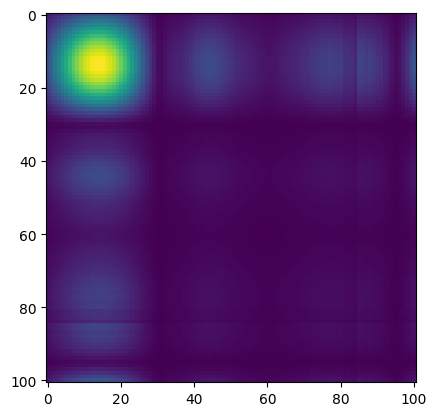

In [129]:
#P = np.fft.ifft2(P)
plt.imshow(np.abs(P))

c:\Users\kissg\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


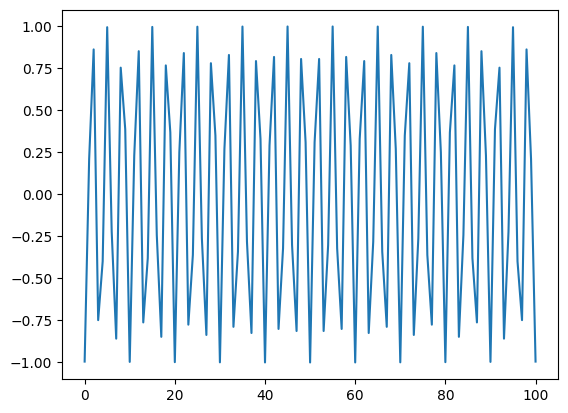

In [125]:
plt.plot(b_vec[:,3])